In [6]:
import os
import sys

cwd = os.getcwd()
project_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(project_dir)

data_path = os.path.join(project_dir, 'data/')
print(project_dir)
print(data_path)

C:\Users\syeon\Desktop\Projects\tagging-music\Tagging-Music-Sequences
C:\Users\syeon\Desktop\Projects\tagging-music\Tagging-Music-Sequences\data/


In [7]:
import torch
import matplotlib.pyplot as plt

import src.models as models
from src.audio_dataset import get_dataloader
from src.trainer import Trainer

import pandas as pd
import numpy as np

import pickle
import seaborn as sns
import os

from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, accuracy_score

In [8]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Trained on gtzan
fcn7_transfer_unfreezed = getattr(models, 'FCN7TransferUnfreezed')
fcn7_transfer_unfreezed = fcn7_transfer_unfreezed().to(device)

fcn7_transfer_2layers = getattr(models, 'FCN7Transfer2Layers')
fcn7_transfer_2layers = fcn7_transfer_2layers().to(device)

fcn7_transfer_1layer = getattr(models, 'FCN7Transfer1Layer')
fcn7_transfer_1layer = fcn7_transfer_1layer().to(device)

In [9]:
# Initialize the Trainer

# Trained with two extra layers, two unfreezed layern augmented
trainer_unfreezed_aug = Trainer(fcn7_transfer_unfreezed)
trainer_unfreezed_aug.load_model('../models/FCN7TransferUnfreezed_aug_final.pth')

# Trained with two extra layers, two unfreezed layer
trainer_unfreezed = Trainer(fcn7_transfer_unfreezed)
trainer_unfreezed.load_model('../models/FCN7TransferUnfreezed_final.pth')

# Trained with two extra layers
trainer_2layers = Trainer(fcn7_transfer_2layers)
trainer_2layers.load_model('../models/FCN7Transfer2Layers_final.pth')

# Trained with one extra layer
trainer_1layer= Trainer(fcn7_transfer_1layer)
trainer_1layer.load_model('../models/FCN7Transfer1Layer_final.pth')


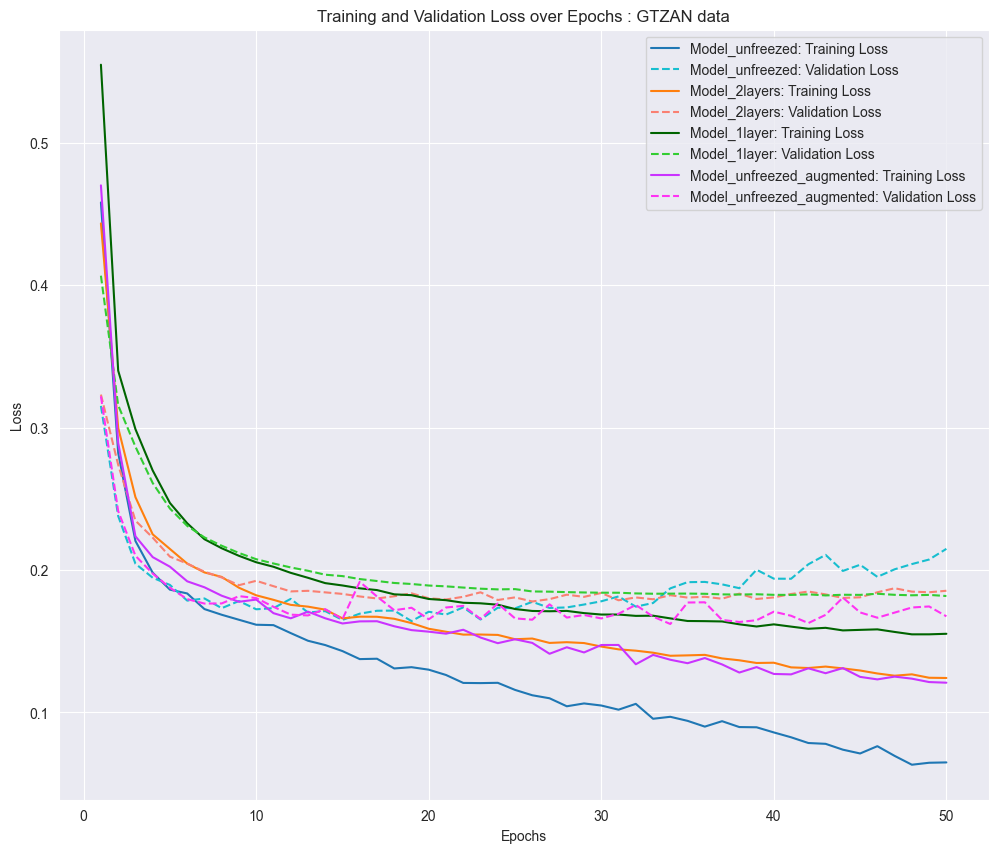

In [10]:
# Models
m = trainer_unfreezed
l = trainer_2layers
p = trainer_1layer
a = trainer_unfreezed_aug

# Epoch range
epochs = range(1, 51) 

plt.figure(figsize=(12, 10))

plt.plot(epochs, m.history['train_loss'], color='#1f77b4', linestyle='-', label='Model_unfreezed: Training Loss')
plt.plot(epochs, m.history['val_loss'], color='#17becf', linestyle='--', label='Model_unfreezed: Validation Loss')


plt.plot(epochs, l.history['train_loss'], color='#ff7f0e', linestyle='-', label='Model_2layers: Training Loss')
plt.plot(epochs, l.history['val_loss'], color='#fa8072', linestyle='--', label='Model_2layers: Validation Loss')


plt.plot(epochs, p.history['train_loss'], color='#006400', linestyle='-', label='Model_1layer: Training Loss')
plt.plot(epochs, p.history['val_loss'], color='#32CD32', linestyle='--', label='Model_1layer: Validation Loss')


plt.plot(epochs, a.history['train_loss'], color='#CA33FF', linestyle='-', label='Model_unfreezed_augmented: Training Loss')
plt.plot(epochs, a.history['val_loss'], color='#FF33F3', linestyle='--', label='Model_unfreezed_augmented: Validation Loss')


plt.title('Training and Validation Loss over Epochs : GTZAN data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Transfer Learning Result Analysis

## ROC AUC, PR AUC, Loss, Accuracy, F1, precision, recall

In [16]:
def calculate_metrics(predicted_probs, true_labels):    
    # Converting probabilistic predictions to class predictions
    predicted_labels = np.argmax(predicted_probs, axis=1)
    true_labels = np.argmax(true_labels, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    
    return accuracy, precision, recall, f1

In [23]:
# Directory containing pickle files
pickle_dir = '../evaluation_results'

files = [
    'FCN7Transfer1Layer_best.pkl',
    'FCN7Transfer2layers_best.pkl',
    'FCN7TransferUnfreezed_best.pkl',
]

# Initialize empty lists to store data
# avg_loss, roc_auc, pr_auc, predicted_labels, true_labels, filepaths
models, roc_aucs, pr_aucs, average_losses, predicted_labels, true_labels, filepaths, accuracies, precisions, recalls, f1s= [], [], [], [], [], [], [], [], [], [], []

evaluation_results = {}

# Iterate over each file and extract data
for file in files:
    # Extract model name from filename (up to the first underscore)
    model_name = file.split('_')[0]
    
    with open(os.path.join(pickle_dir, file), 'rb') as f:
        evaluation_result = pickle.load(f)
        
    evaluation_results[model_name] = evaluation_result
    
    # Store the data for dataframe
    models.append(model_name)
    roc_aucs.append(evaluation_result[1])
    pr_aucs.append(evaluation_result[2])
    average_losses.append(evaluation_result[0])
    # predicted_labels.append(evaluation_result[3])
    # true_labels.append(evaluation_result[4])
    # filepaths.append(evaluation_result[5])
    concatenated_predicted_probs = np.concatenate(evaluation_result[3])
    concatenated_true_labels = np.concatenate(evaluation_result[4])
    
    # Calculate accuracy, precision, recall, and F1
    accuracy, precision, recall, f1 = calculate_metrics(concatenated_predicted_probs, concatenated_true_labels)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
    

# Creating DataFrame for comparison
evaluation_results_df = pd.DataFrame({
    'Model': models,
    'ROC AUC': roc_aucs,
    'PR AUC': pr_aucs,
    # 'Average Loss': average_losses,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1s
})


print(evaluation_results_df)

                   Model   ROC AUC    PR AUC  Accuracy  Precision    Recall  \
0     FCN7Transfer1Layer  0.892505  0.631282     0.585   0.571113  0.607126   
1    FCN7Transfer2layers  0.890856  0.622516     0.560   0.555471  0.580159   
2  FCN7TransferUnfreezed  0.917804  0.702856     0.620   0.615160  0.628788   

   F1 Score  
0  0.575148  
1  0.557577  
2  0.612846  


### 1.2 Visualisation

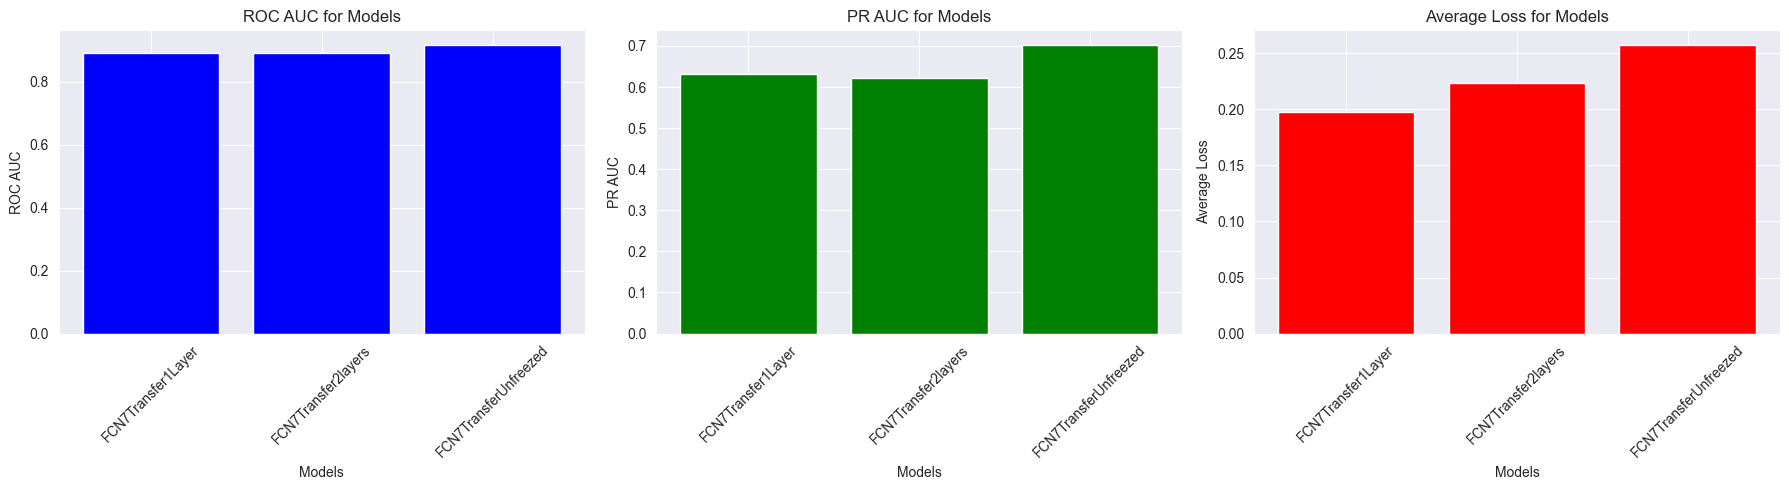

In [22]:
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Set the tick positions and labels for each subplot
for i in range(3):
    ax[i].set_xticks(range(len(models)))
    ax[i].set_xticklabels(models, rotation=45)

# ROC AUC Bar Chart
ax[0].bar(range(len(models)), roc_aucs, color='blue')
ax[0].set_title('ROC AUC for Models')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('ROC AUC')

# PR AUC Bar Chart
ax[1].bar(range(len(models)), pr_aucs, color='green')
ax[1].set_title('PR AUC for Models')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('PR AUC')

# Average Loss Bar Chart
ax[2].bar(range(len(models)), average_losses, color='red')
ax[2].set_title('Average Loss for Models')
ax[2].set_xlabel('Models')
ax[2].set_ylabel('Average Loss')

plt.tight_layout()
plt.show()


### 1.3 Choose model to evaluate

In [66]:
evaluated_model = 'trainer_mel7_l2'